# Background

[Nightwish](https://nightwish.com/) is a symphonic power metal band from Finland and one of the biggest names in the European metal scene. Since 1996, they have released 9 studio albums and numerous singles, EP's, and live albums. The most recent album *Human. :II: Nature.* just came out in April 2020. Throughout their career, Nightwish has explored a wide variety of themes, ranging from personal topics to science and nature. As a Nightwish fan and aspiring data scientist, I thought it might be interesting to look at how the lyrical themes of Nightwish have evolved over the past 24 years.

Inpsired by the [Taylor Swift dataset](https://www.kaggle.com/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums) on Kaggle ([example analysis](https://news.codecademy.com/taylor-swift-lyrics-machine-learning/)), I scraped all of Nightwish's lyrics from the metal lyrics archive [Dark Lyrics](http://www.darklyrics.com/) [(script)](https://github.com/medakk/darklyrics-scraper) and shared [my dataset](https://www.kaggle.com/crazyrichbayesians/nightwish-lyrics) on Kaggle. Eventually, I want to use topic modeling to find out the most common topics in Nightwish songs and examine how they have changed over time. Even cooler, it may be possible to train a neural net to write new lyrics in the style of Nightwish!

Before all that fancy modeling, I'll do some exploratory data analysis (EDA) first. For instance, how do lyrics cluster together? How can we represent them in a low-dimensional space?... This notebook is dedicated to EDA of the Nightwish lyrics dataset.

# Data preparation

In [1]:
# Import libraries
import re
import warnings

import en_core_web_lg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import spacy
import umap
from gensim.models import word2vec
from sklearn import metrics
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

import clean
import word_2dviz

pd.options.mode.chained_assignment = None

warnings.filterwarnings("ignore")

%load_ext lab_black

unable to import 'smart_open.gcs', disabling that module


## Load data

In [2]:
# Read from text file
with open("nightwish_lyrics.txt") as f:
    raw = f.read().splitlines()

In [3]:
# Get rid of unwanted strings
raw = [
    re.sub(r"\*{2,}", "", str(i)) for i in raw
]  # Dividers '****************************'

raw = [i for i in raw if i]  # Empty strings

raw = [i for i in raw if "[" not in i]  # Strings containing "["

In [4]:
# Convert to dataframe
df = pd.DataFrame(raw, columns=["lyric"])

## Text mining
With all information cramped into one column, the information in the original dataset is hard to use. The goal of text mining is to extract album titles, years, track titles, track numbers, and lyrics from the original data and create a separate column for each.

In [5]:
# Function for extracting titles
def title_extract(idx_start):

    # Where album/song ends
    idx_end = idx_start[1:]

    idx_end.append(len(df))

    # Number of lines in album/song
    lines = [i - j for i, j in zip(idx_end, idx_start)]

    # Album/song titles
    titles = df["lyric"].iloc[idx_start].values.tolist()

    # Repeat titles by the number of lines
    titles_nested = [[i] * j for i, j in zip(titles, lines)]

    # Return as a list
    return [item for items in titles_nested for item in items]

In [6]:
# Find beginning of ablum titles
album_start = df.index[df["lyric"].str.contains("*", regex=False)].tolist()

# Add album titles
df["album"] = title_extract(album_start)

# Remove album rows
df = df.drop(album_start).reset_index(drop=True)

# Find beginning song titles
song_start = df.index[df["lyric"].str.contains(r"^[0-9]{1,2}\.\s", regex=True)].tolist()

# Add song titles
df["track"] = title_extract(song_start)

# Remove song rows
df = df.drop(song_start).reset_index(drop=True)

In [7]:
# Extract album titles
df["album_title"] = df["album"].apply(
    lambda x: (
        re.findall(r'"([^"]*)"', x)[0] if re.findall(r'"([^"]*)"', x) else "Non-Album"
    )
)

# Extract years
df["year"] = df["album"].apply(
    lambda x: (
        re.findall(r"\(([^)]+)", x)[0]
        if re.findall(r'"([^"]*)"', x)
        else "Unknown Year"
    )
)

# Extract track titles and numbers
df["track_title"] = df["track"].apply(lambda x: str(x).split(". ")[1])

df["track_number"] = df["track"].apply(lambda x: str(x).split(". ")[0])

# Drop original ablum and track columns
df.drop(["album", "track"], axis=1, inplace=True)

## Word2Vec
A powerful way to represent word meanings is [Word2Vec](https://en.wikipedia.org/wiki/Word2vec). The input can be words, phrases, and sentences and the output is a vector that represents each word/phrase/sentence. The cool thing is that those close in meaning are also closer in the vector space. Several Python libraries can implement Word2Vec. Here I'm using the most popular two, spaCy and Gensim. Text cleaning comes first.


### Text cleaning
I created a custom module `clean`for text cleaning, which includes functions for normalization, stop word removal, and lemmatization.

#### Normalization

First of all, we want the same words to be treated as the same. This means we need to deal with cases (e.g., "Have" vs. "have"), contradictions (e.g., "it's" vs. "it is"), misspellings (e.g., "believ" vs. "believe"), etc. It's also a [standard practice](https://www.kaggle.com/saga21/disaster-tweets-comp-introduction-to-nlp/notebook) in Natural Language Processing (NLP) to replace accented characters ( e.g., "Élan") with "plain" characters (e.g., "Elan") and to remove punctuations, white spaces, etc. that don't bear any meanings. This whole process is often called "normalization".

The `clean` module has 6 normalization functions: `lower_case()`, `expand_contractions()`, `remove_punct()`, `remove_accented_chars()`,  `correct_spellings()`, and `remove_space()`. The catch-all `normalization()` function executes them in exactly this order.

In [8]:
# Normalization
df["lyric_normalized"] = df["lyric"].apply(lambda x: clean.normalization(x))

In [9]:
# Remove new punctuations created by SpellChecker()
df["lyric_normalized"] = df["lyric_normalized"].apply(lambda x: clean.remove_punct(x))

# Remove new spaces
df["lyric_normalized"] = df["lyric_normalized"].apply(lambda x: clean.remove_space(x))

#### Stop word removal
[Stop words](https://kavita-ganesan.com/what-are-stop-words/#.Xp9ZE9NKjpA) are common words that don't often contribute new information, such as pronouns (e.g., I, its, yourself, etc.), determiners (e.g., a, the), conjunctions (e.g., for, an, nor, but, or, yet, so), and prepositions (e.g., in, under, towards, before). We can use the spaCy library to remove stop words.

In [10]:
# Load pre-trained English model
nlp = en_core_web_lg.load()

In [11]:
# Remove stop words
df["lyric_nostop"] = df["lyric_normalized"].apply(
    lambda x: clean.remove_stopwords(nlp(x))
)

#### Lemmatization
Words like "wanted", "wants", and "want" share the same root but have different inflectional forms. Instead of representing each form separately, we can use "lemmatization" to return each word to its [lemma](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) (i.e., its base or dictionary form). The spaCy libarary also makes lemmatization really convenient.

In [12]:
# Lemmatize words
df["lyric_lemma"] = df["lyric_nostop"].apply(lambda x: clean.lemmatizer(nlp(x)))

#### Save results
We can save the cleaned dataset so in the future we don't have to go through the entire process from scratch.

In [13]:
# Save as CSV
df.to_csv("nightwish_lyrics.csv", index=False, header=True)

In [14]:
# Drop rows that no longer have lyrics
df_clean = df.dropna()

### Word embeddings
We can use Word2Vec to create word embeddings on different levels. For instance, we can create a vector for each line of lyrics or we can do it for each word in Nightwish's "vocabulary". I'm doing both below.

#### Each line of lyrics
I used a pre-trained model in spaCy to create a vector for each line of lyrics, which is the average vector across all words in that line.

In [15]:
# Average vectors for each line of lyrics
X_lyric = np.array(
    [nlp(lyric["lyric_lemma"]).vector for idx, lyric in df_clean.iterrows()]
)

# Center the vectors
vec_mean = X_lyric.mean(axis=0)

X_lyrics = pd.DataFrame([vec - vec_mean for vec in X_lyric])

#### Each word in vocabulary
Alternatively, we can put all the words Nightwish has ever used together in two a single corpus and create a vector for each word in this corpus.

In [16]:
# Create a corpus
corpus = df_clean["lyric_lemma"].tolist()

corpus = [i for i in corpus if i]

# Tokenize sentences
tokenized_sentences = [sentence.split() for sentence in corpus]

# Train model (words should appear at least 10 times)
model = word2vec.Word2Vec(tokenized_sentences, min_count=10)

# Save model
model.save("model.bin")

# Retrieve vectors
X_vocab = model[model.wv.vocab]

#### Standardization
Since methods such as PCA can be sensitive to scales, let's standardize the vectors before using them.

In [17]:
# Embeddings of lyrics
lyrics_scaler = StandardScaler()
X_lyrics_std = lyrics_scaler.fit_transform(X_lyrics)

# Embeddings of vocabulary
vocab_scaler = StandardScaler()
X_vocab_std = vocab_scaler.fit_transform(X_vocab)

# Cluster analysis
Instead of using all columns in word embeddings, I'm going to extract two principle components and use them to train models. In the interest of space, I'll focus on vocabulary-level embeddings below. The first question is, **how many clusters does Nightwish's lyrical vocabulary have?** 

Since our data doesn't have labels, we can use the silhouette score to evaluate clustering results. This metric measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Higher values indicate more appropriate clusters.

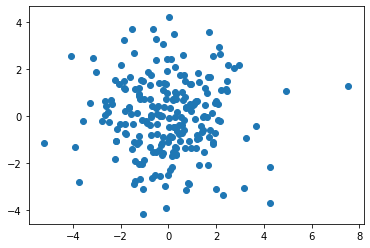

In [18]:
# Extract 2 principle components
X_vocab_pca = PCA(n_components=2).fit_transform(X_vocab_std)

# Visualize on a 2D plane
plt.scatter(X_vocab_pca[:, 0], X_vocab_pca[:, 1])
plt.show()

## k-means
The simplest clustering algorithm is k-means. The hyper-paramter k determines the number of clusters to use. We can try k from 1 to 10 to see which value might be the optimal trade-off between complexity and model fit. I'll use the "elbow method" to find such a point.

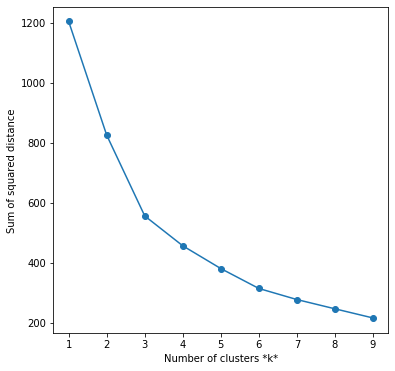

In [19]:
# Elbow method: Plot sse against k
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_vocab_pca)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, "-o")
plt.xlabel(r"Number of clusters *k*")
plt.ylabel("Sum of squared distance")
plt.show()

There isn't an obvious elbow with a sharp decrease but it seems the sum of squared distance doesn't drop too much when k increases from 4. So let's set the number of clusters to be 4.

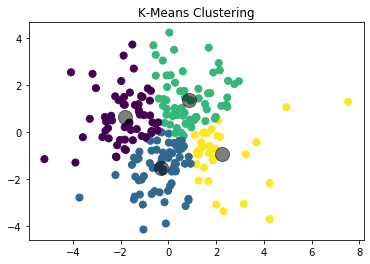

The silhouette score of k-means using 4 clusters is 0.32.


In [20]:
# Create KMeans object using k=4
kmeans = KMeans(n_clusters=4, random_state=123)

# Fit model
y_kmeans = kmeans.fit_predict(X_vocab_pca)

# Visualize results
plt.scatter(X_vocab_pca[:, 0], X_vocab_pca[:, 1], c=y_kmeans, s=50, cmap="viridis")
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5)
plt.title("K-Means Clustering")
plt.show()

# Evaluate results
kmeans_silhouette = round(float(metrics.silhouette_score(X_vocab_pca, y_kmeans)), 2)
print(f"The silhouette score of k-means using 4 clusters is {kmeans_silhouette}.")

## Hierarchical clustering
Rather than specifying the number of clusters beforehand, we can let the algorithm "discover" clusters on the fly. Hierarchical clustering is such an algorithm. There are different ways of assigning observations to clusters, each called a different linkage method. We can try different methods to see which one works the best for our data.

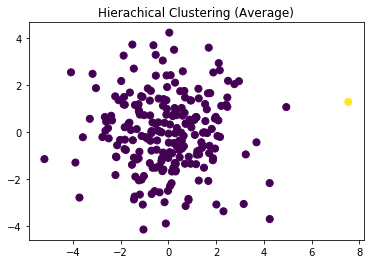

The silhouette score of hierarchical clustering (average) is 0.62.


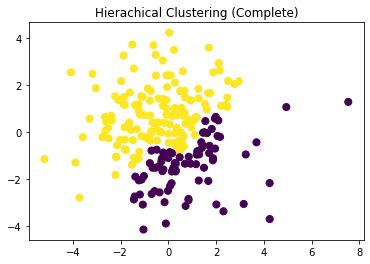

The silhouette score of hierarchical clustering (complete) is 0.28.


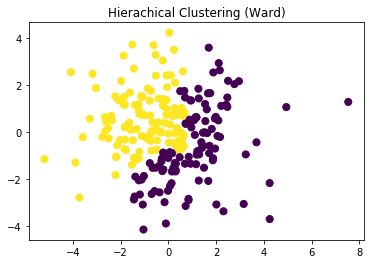

The silhouette score of hierarchical clustering (ward) is 0.25.


In [21]:
# Try different linkage methods
links = ["average", "complete", "ward"]

for link in links:

    # Create object using each method
    hier_model = AgglomerativeClustering(linkage=link, affinity="euclidean")

    # Fit model
    y_hier = hier_model.fit_predict(X_vocab_pca)

    # Visualize results
    plt.scatter(X_vocab_pca[:, 0], X_vocab_pca[:, 1], c=y_hier, s=50, cmap="viridis")
    plt.title(f"Hierachical Clustering ({link.capitalize()})")
    plt.show()

    # Evaluate results
    hier_silhouette = round(float(metrics.silhouette_score(X_vocab_pca, y_hier)), 2)
    print(
        f"The silhouette score of hierarchical clustering ({link}) is {hier_silhouette}."
    )

Judging from silhouette scores, the average method works the best and is a huge improvement from k-means clustering results. According to this method, almost all observations belong to one big cluster, with just one exception.

## DBSCAN
DBSCAN is another algorithm that discovers clusters as it goes. It starts with a random point and finds all the density-reachable points to cluster together. We can adjust the largest radius for expanding clusters ($\epsilon$) and the minimum number of points needed to form a cluster ("MinPts").

In [22]:
# Hyper-parameter tuning
eps_list = np.linspace(0.1, 10, num=100, endpoint=False)
min_samples_list = np.linspace(1, 30, num=30, endpoint=True)

scores = {}
for eps in eps_list:
    for min_samples in min_samples_list:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        pred = dbscan_model.fit_predict(X_vocab_pca)
        key = "eps = {}, MinPts = {}".format(round(eps, 2), round(min_samples, 1))
        try:
            scores[key] = metrics.silhouette_score(X_vocab_pca, pred)
        except:
            pass

# Show results
max_score = round(float(scores.get(max(scores, key=scores.get))), 2)

print(f"Highest Silhouette score was {max_score} when {max(scores, key=scores.get)}")

Highest Silhouette score was 0.62 when eps = 1.98, MinPts = 1.0


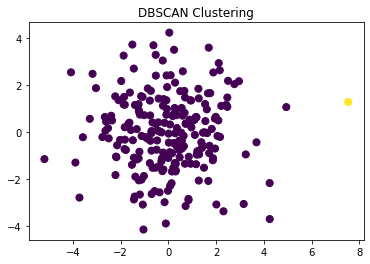

The silhouette score of DBSCAN using 2 clusters is 0.62.


In [26]:
# Fit with best model
dbscan = DBSCAN(eps=1.98, min_samples=1)
y_dbscan = dbscan.fit_predict(X_vocab_pca)

# Visualize results
plt.scatter(X_vocab_pca[:, 0], X_vocab_pca[:, 1], c=y_dbscan, s=50, cmap="viridis")
plt.title("DBSCAN Clustering")
plt.show()

# Evaluate results
dbscan_silhouette = round(float(metrics.silhouette_score(X_vocab_pca, y_dbscan)), 2)
print(f"The silhouette score of DBSCAN using 2 clusters is {dbscan_silhouette}.")

DBSCAN with the best-fitting hyper-parameters achieved similar results as hierarchical clustering using the Ward method. It also views all observations as belong to one cluster, with few in a different cluster.

## GMM
All the clustering methods above assume that one observation belongs to only one cluster. This type of algorithm is so-called hard clustering algorithms. Alternatively, one observation can belong to any cluster with differing probabilities. This is soft clustering. A popular soft clustering algorithm is Gaussian Mixture Models (GMMs) where data are assumed to be generated by multiple Gaussian distributions. Let's try GMM.

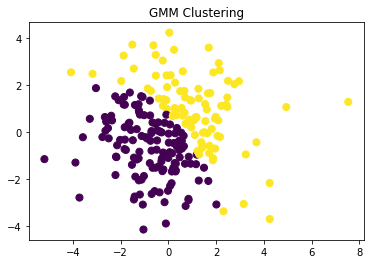

The silhouette score of GMM using 2 clusters is 0.3.


In [27]:
# Create model project
gmm = GaussianMixture(n_components=2, random_state=123)

# Predict clusters
y_gmm = gmm.fit_predict(X_vocab_pca)

# Visualize results
plt.scatter(X_vocab_pca[:, 0], X_vocab_pca[:, 1], c=y_gmm, s=50, cmap="viridis")
plt.title("GMM Clustering")
plt.show()

# Evaluate results
gmm_silhouette = round(float(metrics.silhouette_score(X_vocab_pca, y_gmm)), 2)
print(f"The silhouette score of GMM using 2 clusters is {gmm_silhouette}.")

GMM inferred two clusters. It didn't perform as well as hierarchical clustering or DBSCAN. So perhaps words in Nightwish's lyrics are indeed similar to one another.

# Dimension reduction
Lastly, let's see which words are similar in space and which ones are far apart. Due to the high number of columns in our word embeddings, it's necessary to use dimension reduction techniques such as PCA, t-SNE, and UMAP. Like before, I created a custom module called "word_2divz" to do the job. To avoid overplotting, I only selected words that appeared at least 10 times.

## PCA

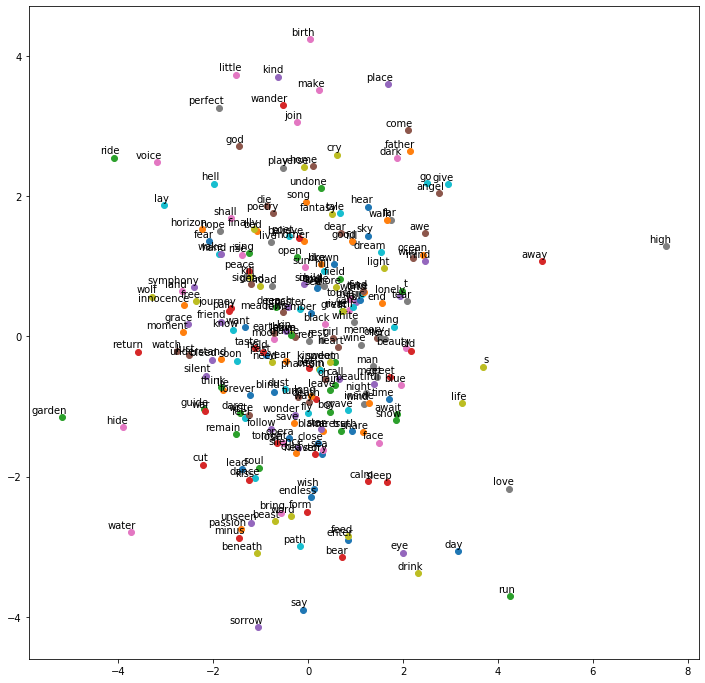

In [28]:
# Dimension reduction using PCA
word_2dviz.pca_plot(model)

PCA puts most words close together, which is not easy to see each word clearly.

## t-SNE

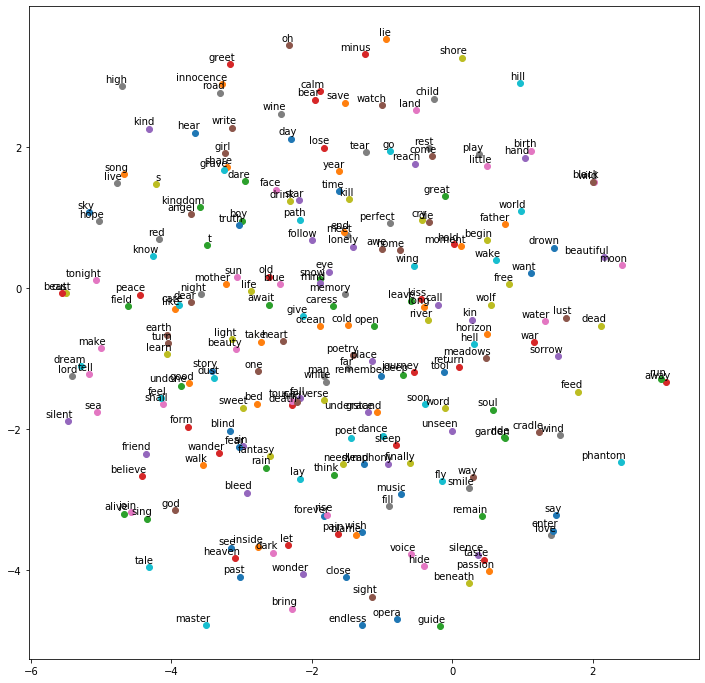

In [29]:
# Dimension reduction using t-SNE
word_2dviz.tsne_plot(model)

t-SNE puts the words further away. For some words that are close together, such as "walk" and "wonder", it makes a lot of sense. 

## UMAP

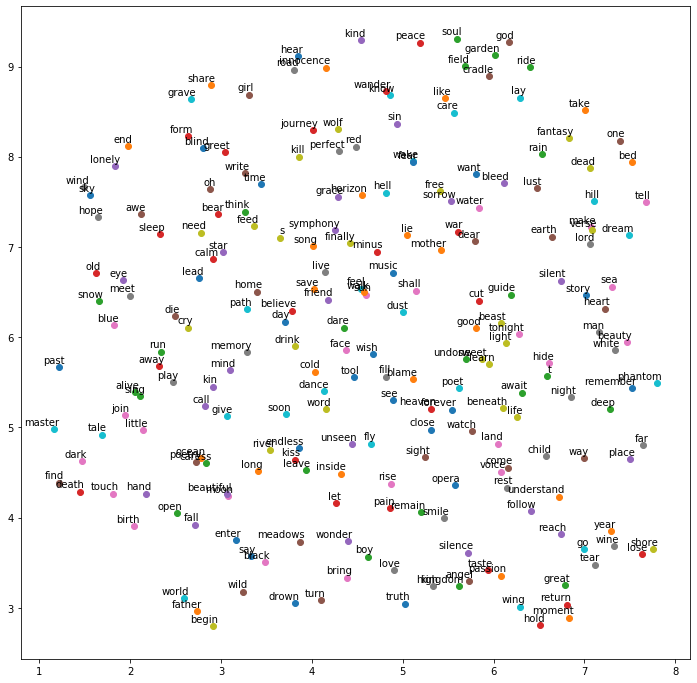

In [30]:
# Dimension reduction using UMAP
word_2dviz.umap_plot(model)

Compared to t-SNE, UMAP puts words even further away. 